# Data Preprocessing

The data is formatted as JSON separated by newline. Using pandas to read dataset

In [84]:
import pyspark.pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.context import SparkContext

sc = SparkContext

spark = SparkSession \
    .builder \
    .appName("Amazon Sentiment Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

dataframe = spark.read.json("./Software_5.json")

print(dataframe.printSchema())
print("Data read", dataframe.count())
print(dataframe.describe())


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)

None
Data read 12805
DataFrame[summary: string, asin: string, overall: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName:

The feature `vote` tells us if the review is helpful or not. To better classifying our data, we want to remove all reviews that have no vote.

Also, note that the data type of `vote` is `object`. But since vote can only be a number, we want to convert vote to `int64` data type

Now after preprocessing the vote, we can see that the data type of vote is `int64`

In [85]:
from pyspark.sql.functions import lower, col, udf
from pyspark.sql.types import StringType, IntegerType

df = dataframe.dropna(how="any", subset=["vote", "overall", "reviewText"])
# Some vote has , in number, we just need to remove it


def convert_to_int(text: str) -> int:
    return int(text.replace(",", ""))


process_vote = udf(lambda q: convert_to_int(q), IntegerType())

df = df.withColumn("vote", process_vote(col("vote")))
print(df.printSchema())


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: integer (nullable = true)

None


For feature `reviewText`, we want to do some pre processing steps on the text. Notably:

- Lemmetization  
- Expand contraction   
- Lower all words

In [87]:
import nltk
import string
import contractions
nltk.download('stopwords')


def remove_special_symbol(text: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def lower_text(text: str) -> str:
    return text.lower()


def remove_stop_words(text: str) -> str:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    return ' '.join(
        [word for word in text.split() if word not in (stop_words)])


def expand_contraction(text: str) -> str:
    return contractions.fix(text)


def stemming(text: str) -> str:
    stemmer = nltk.stem.SnowballStemmer("english")
    return stemmer.stem(text)


process_review = udf(lambda q: stemming(remove_special_symbol(
    remove_stop_words(expand_contraction(lower_text(q))))), StringType())

df = df.withColumn("processed_review", process_review(col("reviewText")))

df.show()


[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|    processed_review|
+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+
|0321719816|                null|    5.0|If you've been wa...|10 16, 2010| ACJT8MUC0LRF0|          D. Fowler|{null,  DVD-ROM, ...|This is excellent...|    1287187200|   false|   3|wanting learn cre...|
|0321719816|                null|    5.0|I have also taken...|10 28, 2010|A2WCFDOCS73PNB|          Gadgetman|{null,  DVD-ROM, ...|Excellent value f...|    1288224000|   false|   4|also taken l

Each review is assigned an overall score from 1.0 to 5.0. Convert those scores to labels where -1 is negative, 0 is neutral and 1 is positive

In [88]:
def sentiment_from_overall(number):
    if number < 3.0:
        return -1
    if number == 3.0:
        return 0
    return 1


add_sentiment = udf(lambda q: sentiment_from_overall(q), IntegerType())
df = df.withColumn("sentiment", add_sentiment(col("overall")))
df.show()


+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+---------+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|    processed_review|sentiment|
+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+---------+
|0321719816|                null|    5.0|If you've been wa...|10 16, 2010| ACJT8MUC0LRF0|          D. Fowler|{null,  DVD-ROM, ...|This is excellent...|    1287187200|   false|   3|wanting learn cre...|        1|
|0321719816|                null|    5.0|I have also taken...|10 28, 2010|A2WCFDOCS73PNB|          Gadgetman|{null,  DVD-ROM, ...|Excellent value f...| 

# Visualization

We first need to convert Spark SQL DataFrame to Panda Dataframe

In [96]:
panda_df = df.toPandas()

Exploratory data analysis on overall rating column

In [97]:
panda_df.describe()

,overall,unixReviewTime,vote,sentiment
count,3902.000000,3.902000e+03,3902.000000,3902.000000
mean,3.367760,1.299909e+09,17.830856,0.250897
std,1.557351,1.107256e+08,101.375764,0.896799
min,1.000000,9.619776e+08,2.000000,-1.000000
25%,2.000000,1.221199e+09,2.000000,-1.000000
50%,4.000000,1.295568e+09,4.000000,1.000000
75%,5.000000,1.393870e+09,11.000000,1.000000
max,5.000000,1.526515e+09,5365.000000,1.000000


Plotting pie chart and bar chart for overall score distribution. The 'overall' column has 5 labels: 1.0, 2.0, 3.0, 4.0, 5.0 where 1.0 is very bad, 3.0 is neutral and 5.0 is very good.

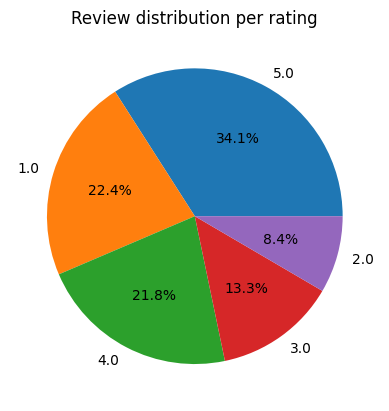

<AxesSubplot: title={'center': 'Review count per rating'}>

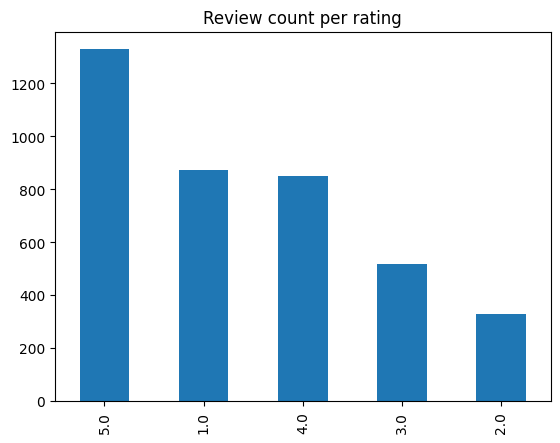

In [99]:
scores = panda_df["overall"].value_counts()
index = scores.index.to_numpy()
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per rating")
plt.show()
panda_df['overall'].value_counts().plot(kind='bar',title="Review count per rating")


We get the same statistic, but this time with sentiment

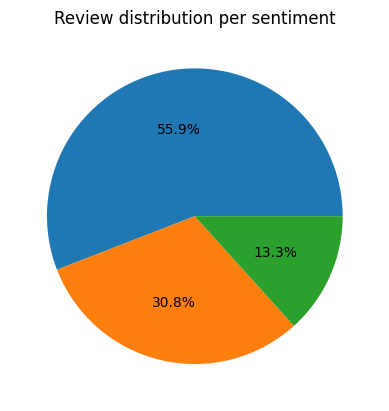

<AxesSubplot: title={'center': 'Review count per sentiment'}>

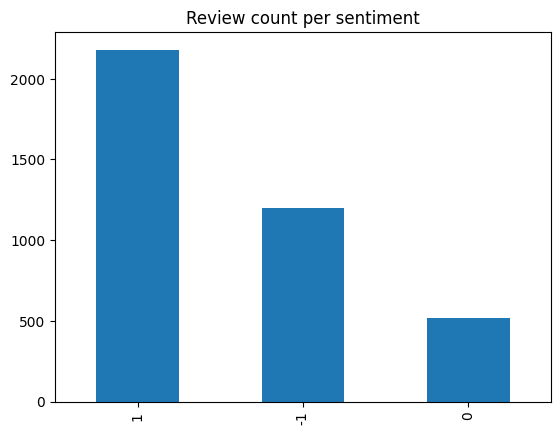

In [103]:
def sentiment_to_word(number):
    if number == 1:
        return "Positive"
    if number == 0:
        return "Negative"
    return "Neutral"

scores = panda_df["sentiment"].value_counts()
index = [sentiment_to_word(x) for x in scores]
scores = scores.to_numpy()
plt.pie(scores, autopct='%1.1f%%')
plt.title("Review distribution per sentiment")
plt.show()
panda_df['sentiment'].value_counts().plot(kind='bar',title="Review count per sentiment")


Now, we get statistics on reivewText length. To visualize this, we use a boxplot

Statistic of text length
 count     3902.000000
mean      1137.915428
std       1409.747266
min          3.000000
25%        361.000000
50%        734.000000
75%       1428.500000
max      23075.000000
Name: processed_review, dtype: float64


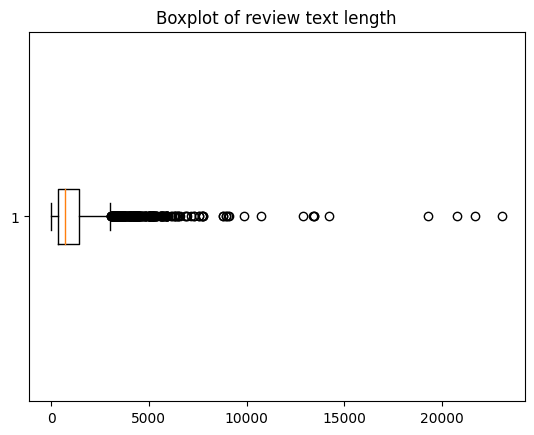

In [104]:
text_length = panda_df["processed_review"].apply(len)
print("Statistic of text length\n", text_length.describe())
# To visualize this, we use boxplot
plt.title("Boxplot of review text length")
plt.boxplot(text_length, vert=False)
plt.show()


Wordcloud to visualize top words in our `processed_review` column

Text(0.5, 1.0, 'Most popular words in dataset')

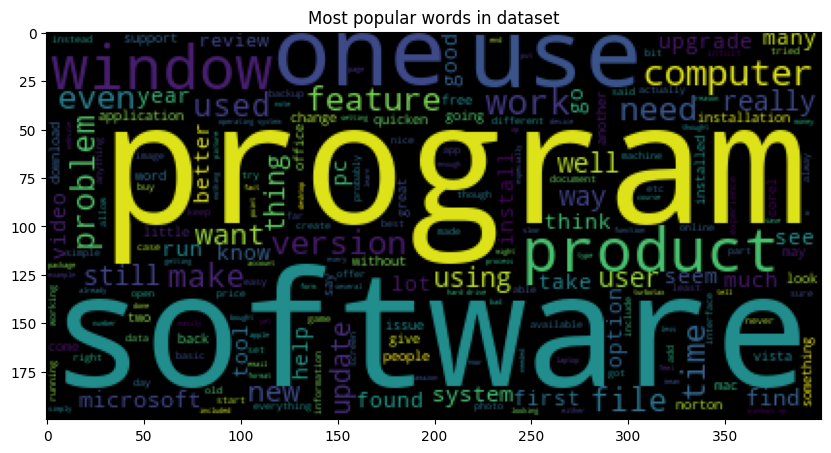

In [105]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(panda_df['processed_review']))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud)
ax.set_title("Most popular words in dataset")


Next up, we want to visualize the correlation between `vote` and `rating` in our dataframe. There is no correlation between `vote` and `rating`. Therefore,
we conclude that by removing samples that have no `vote`, it creates no bias for our dataset

<AxesSubplot: title={'center': 'Correlation between features'}>

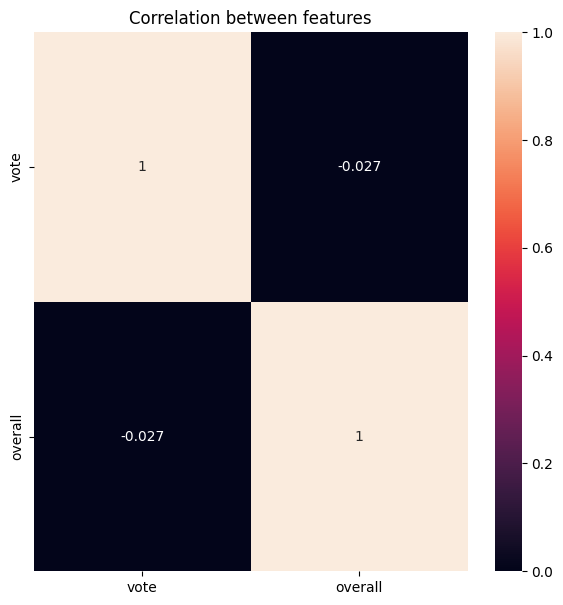

In [108]:
from seaborn import heatmap

correlation = panda_df[["vote", "overall"]].corr()
plt.figure(figsize=(7, 7))
plt.title("Correlation between features")
heatmap(correlation, vmin=0, vmax=1, annot=True)


# Algorithms

We will separate our data into 3 sets which are `trainning`, `validation` and `testing`.

The trainning step will be used to create our model, we want to config parameters that will generalize well in this step

Validation step will be used for hyperparameter tuning, to maximize our model's accuracy.

Finally, we measure and compare our results using the test set.

We will split the dataset in the following ration: 80, 10 and 10.

In [110]:
# Split dataset
print(df.describe())

DataFrame[summary: string, asin: string, overall: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: string, vote: string, processed_review: string, sentiment: string]


Next up, we need to extract features from our text data. This will act as an input to our ML model. There are many options that we can choose from, notably:

1, **TF-IDF**: Stands for Term Frequency – Inverse Document Frequency

2, **Count Vectorizer**

We will use TF-IDF for feature extraction. The reason is that Count Vectorizer only focuses on the frequency of the word, which results in biasing in favour of popular words. For example, the word `the` will be counted a lot but does not hold any significant meaning. Meanwhile, using TF-IDF, we can avoid common words that does not carry any sentiment

In [111]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="processed_review",
                      outputCol="tokenized_review")
word_data = tokenizer.transform(df)
# Use TF IDF
print(word_data)


Next up, we will train our model using `Logistic Regression`

In [ ]:
# Train model with Logistic Regression

Visualizing the result

In [ ]:
# Show accuracy score, f1 score, recall score and confusion matrix